# Machine Learning for Prediciton of Bus Stop Demand
This follows on from the SEQ analysis notebook found in this Github directory.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

df = pd.read_csv('./data/ML_data.csv', index_col=0)

# Preprocessing

In [2]:
# Get features and target
X = df.drop(['quantity_class'], axis=1)
y = df['quantity_class']

In [3]:
# Separate features for scaling
scale_list = ['frequency', 'Median_age_persons', 'Med_mort_repaymnt_monthly', 'Median_rent_weekly', 'Med_tot_hh_incom_weekly', 'Average_household_size']
X_scale = X[scale_list]
X_no_scale = X.drop(scale_list, axis=1)

# Split  data into training and testing sets
X_train_scale, X_test_scale, X_train_no_scale, X_test_no_scale, y_train, y_test = train_test_split(X_scale, X_no_scale, y, test_size=0.2, random_state=12)

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.concat([pd.DataFrame(scaler.fit_transform(X_train_scale), columns=scale_list, index=X_train_scale.index), X_train_no_scale], axis=1)
X_test_scaled = pd.concat([pd.DataFrame(scaler.transform(X_test_scale), columns=scale_list, index=X_test_scale.index), X_test_no_scale], axis=1)

In [8]:
# Encode target
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Model Without Cross Validation or Tuning
As shown, running a model without cross validation or tuning results in a low accuracy.

In [5]:
# Establish XGBoost model
model = xgb.XGBClassifier()

# Fit the model
model.fit(X_train_scaled, y_train_encoded)
# Undertake predictions
predictions = model.predict(X_test_scaled)

In [6]:
# Evaluate accuracy
accuracy = accuracy_score(y_test_encoded, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Display confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, predictions)
print('Confusion Matrix:')
print(conf_matrix)

# Display classification report
class_report = classification_report(y_test_encoded, predictions)
print('Classification Report:')
print(class_report)

Accuracy: 0.50
Confusion Matrix:
[[185  13  46  12]
 [ 32 106  71  84]
 [ 70  53 105  46]
 [ 14  71  42 162]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       256
           1       0.44      0.36      0.40       293
           2       0.40      0.38      0.39       274
           3       0.53      0.56      0.55       289

    accuracy                           0.50      1112
   macro avg       0.50      0.51      0.50      1112
weighted avg       0.49      0.50      0.50      1112



# Model with Cross Validation and Tuning
A 5-fold randomised search has been undertaken as part of tuning. In addition to this, a grid search was also undertaken to see if further improvements could be found.

In [9]:
# Assuming X_train_scaled, y_train_encoded are your training data
rand_param = {
    'learning_rate': np.arange(0.01, 0.50, 0.01),
    'max_depth': np.arange(3, 6, 1),
    'subsample': np.arange(0.2, 1.0, 0.05),
    'colsample_bytree': np.arange(0.2, 1.0, 0.05)
}

rand_search = RandomizedSearchCV(estimator=model, param_distributions=rand_param, n_iter=100, scoring='accuracy', cv=5, verbose=2)
rand_search.fit(X_train_scaled, y_train_encoded)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=0.6499999999999999, learning_rate=0.34, max_depth=5, subsample=0.7499999999999998; total time=  16.2s
[CV] END colsample_bytree=0.6499999999999999, learning_rate=0.34, max_depth=5, subsample=0.7499999999999998; total time=  16.8s
[CV] END colsample_bytree=0.6499999999999999, learning_rate=0.34, max_depth=5, subsample=0.7499999999999998; total time=  17.8s
[CV] END colsample_bytree=0.6499999999999999, learning_rate=0.34, max_depth=5, subsample=0.7499999999999998; total time=  16.9s
[CV] END colsample_bytree=0.6499999999999999, learning_rate=0.34, max_depth=5, subsample=0.7499999999999998; total time=  17.0s
[CV] END colsample_bytree=0.9499999999999997, learning_rate=0.12, max_depth=5, subsample=0.39999999999999997; total time=  16.6s
[CV] END colsample_bytree=0.9499999999999997, learning_rate=0.12, max_depth=5, subsample=0.39999999999999997; total time=  16.7s
[CV] END colsample_bytree=0.94999999999

In [11]:
best_score = rand_search.best_score_
best_params = rand_search.best_params_
best_model = rand_search.best_estimator_
feature_importance = best_model.feature_importances_

print(best_score)
print(best_params)
print(best_model)
print(feature_importance)

0.5014623172103486
{'subsample': 0.7999999999999998, 'max_depth': 5, 'learning_rate': 0.08, 'colsample_bytree': 0.7499999999999998}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7499999999999998, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
[0.34368926 0.08490888 0.08673248 0.08308205 0.09546416 0.11135369
 0.10255034 0.0922191 ]


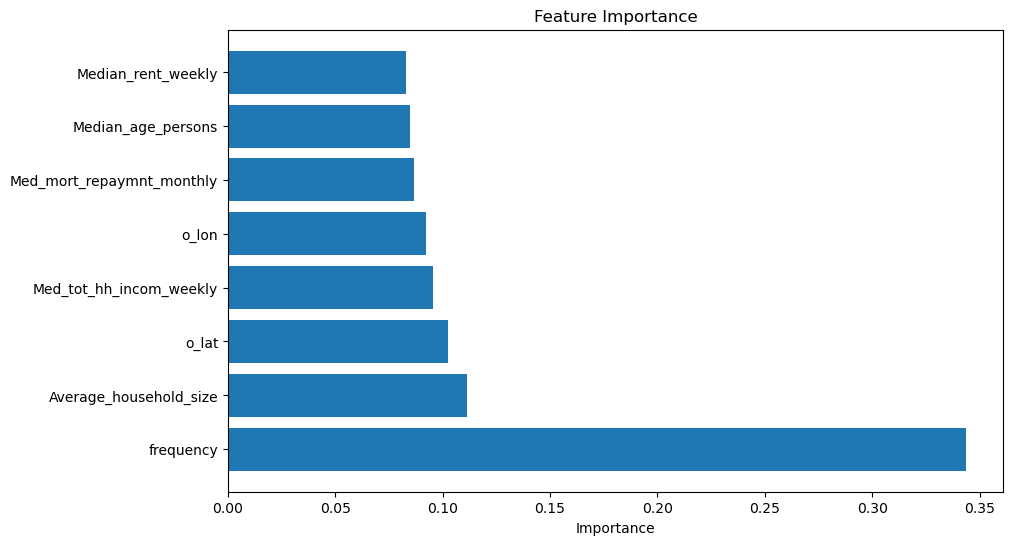

In [12]:
# Plotting feature importance
feature_names = X_train_scaled.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [13]:
# Set up parameters
grid_param = {'learning_rate': np.arange(0.05, 0.10, 0.01),
          'max_depth': [5],
          'subsample': [0.8, 0.85, 0.9],
          'colsample_bytree': [0.70, 0.75, 0.80]}

# Run model
grid_search = GridSearchCV(estimator=model, param_grid=grid_param, scoring='accuracy', cv=5, verbose=1)
grid_search.fit(X_train_scaled, y_train_encoded)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob', predictor=None, ...),
             param_grid={'colsample_bytree': [0.7, 0.75, 0.8],
                         'learning_rate': array([0.05, 0.06, 0.07, 0.08, 0.09]),
                         'max_depth': [5], 'subsample': [0.8, 0.85, 0.9]},
             scoring='accuracy', verbose=1)

In [15]:
best_score = grid_search.best_score_
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_score)
print(best_params)
print(best_model)

0.5059617547806525
{'colsample_bytree': 0.75, 'learning_rate': 0.07, 'max_depth': 5, 'subsample': 0.85}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


# Initial Results

In [16]:
best_model = xgb.XGBClassifier(colsample_bytree=0.75, learning_rate=0.07, max_depth=5, subsample=0.85)
best_model.fit(X_train_scaled, y_train_encoded)
predictions = best_model.predict(X_test_scaled)

In [17]:
# Evaluate accuracy
accuracy = accuracy_score(y_test_encoded, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Display confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, predictions)
print('Confusion Matrix:')
print(conf_matrix)

# Display classification report
class_report = classification_report(y_test_encoded, predictions)
print('Classification Report:')
print(class_report)

Accuracy: 0.47
Confusion Matrix:
[[193   7  42  14]
 [ 38  88  81  86]
 [ 80  55  86  53]
 [ 24  67  40 158]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.75      0.65       256
           1       0.41      0.30      0.35       293
           2       0.35      0.31      0.33       274
           3       0.51      0.55      0.53       289

    accuracy                           0.47      1112
   macro avg       0.46      0.48      0.46      1112
weighted avg       0.46      0.47      0.46      1112



At this stage, the parameters obtained from the grid search result in a model that does not perform as well as the default XGBoost model used. 

Further work is required to improve performance, including (but not limited to):
 - improved hyperparameter tuning
 - refinement of features used (including identifying new features for inclusion and potentially removing existing features)
 - consideration of other ML algorithms
 - eventual progression towards time series forecasting.